In [1]:
import pandas as pd
import datetime
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt

start = datetime.datetime(2018, 1, 1)
end = datetime.datetime.today()

SERIES = {
    "REAL_GDP": "GDP",
    "IND_PROD": "INDPRO",
    "RETAIL_SALES": "RSXFS",
    "UNEMP_RATE": "UNRATE",
    "CPI_HEAD": "CPIAUCSL",
    "CPI_CORE": "CPILFESL",
    "PPI": "PPIACO",
    "YC_10Y_2Y": "T10Y2Y",
    "REAL_YIELD_10Y": "DFII10",
    "CREDIT_SPREAD_BAA10Y": "BAA10Y",
    "INFL_EXP_5Y5Y": "T5YIFR",
}

dfs = []
for col, code in SERIES.items():
    try:
        s = pdr.DataReader(code, "fred", start, end)
        s.columns = [col]
        dfs.append(s)
        print(f"Loaded {code} ({len(s)} records)")
    except Exception as e:
        print(f"Failed to fetch {code}: {e}")

df = pd.concat(dfs, axis=1)

df.to_csv("macro_data_since2018.csv")
print("Combined dataset shape:", df.shape)
df.tail()



Loaded GDP (30 records)
Loaded INDPRO (92 records)
Loaded RSXFS (92 records)
Loaded UNRATE (92 records)
Loaded CPIAUCSL (92 records)
Loaded CPILFESL (92 records)
Loaded PPIACO (92 records)
Loaded T10Y2Y (2035 records)
Loaded DFII10 (2034 records)
Loaded BAA10Y (2034 records)
Loaded T5YIFR (2035 records)
Combined dataset shape: (2061, 11)


,REAL_GDP,IND_PROD,RETAIL_SALES,UNEMP_RATE,CPI_HEAD,CPI_CORE,PPI,YC_10Y_2Y,REAL_YIELD_10Y,CREDIT_SPREAD_BAA10Y,INFL_EXP_5Y5Y
DATE,,,,,,,,,,,
2025-10-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-10-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.55,1.73,1.71,2.27
2025-10-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.55,1.76,1.68,2.25
2025-10-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.58,1.71,1.71,2.27
2025-10-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.56,NaN,NaN,2.25


In [2]:
from google.colab import files
files.download("macro_data_since2018.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
from sklearn.preprocessing import StandardScaler

def preprocess_monthly_impute_standardize(
    df: pd.DataFrame,
    date_col: str | None = None,
    impute_method: str = "linear",
    monthly_rule: str = "M",
    take_func: str = "last",
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, StandardScaler]:

    data = df.copy()

    if date_col is not None:
        data[date_col] = pd.to_datetime(data[date_col])
        data = data.set_index(date_col).sort_index()
    else:
        if not isinstance(data.index, pd.DatetimeIndex):
            raise ValueError("Provide a datetime index or specify `date_col`.")
        data = data.sort_index()

    if take_func == "last":
        df_monthly = data.resample(monthly_rule).last()
    else:
        df_monthly = getattr(data.resample(monthly_rule), take_func)()

    if impute_method in ("linear", "time"):
        df_imputed = df_monthly.interpolate(method=impute_method, limit_direction="both")
    elif impute_method == "ffill":
        df_imputed = df_monthly.ffill().bfill()
    elif impute_method == "bfill":
        df_imputed = df_monthly.bfill().ffill()
    else:
        raise ValueError("impute_method must be one of {'linear','time','ffill','bfill'}")

    scaler = StandardScaler()
    df_standardized = pd.DataFrame(
        scaler.fit_transform(df_imputed),
        index=df_imputed.index,
        columns=df_imputed.columns,
    )

    return df_monthly, df_imputed, df_standardized, scaler


In [4]:
raw = pd.read_csv("macro_data_since2018.csv", parse_dates=["DATE"])
col_daily = ['DATE','YC_10Y_2Y', 'REAL_YIELD_10Y', 'CREDIT_SPREAD_BAA10Y', 'INFL_EXP_5Y5Y']
df_daily = raw[col_daily]
col_monthly = ['DATE','IND_PROD', 'RETAIL_SALES', 'UNEMP_RATE', 'CPI_HEAD', 'CPI_CORE', 'PPI']
df_monthly = raw[col_monthly]
col_quarterly = ['DATE','REAL_GDP']
df_quarterly = raw[col_quarterly]

df, df_imputed_daily, df_std_daily, scaler = preprocess_monthly_impute_standardize(
    df_daily,
    date_col="DATE",
    impute_method="linear",
    monthly_rule="M",
    take_func="mean"
)
monthly_df, df_imputed_monthly, df_std_monthly, scaler = preprocess_monthly_impute_standardize(
    df_monthly,
    date_col="DATE",
    impute_method="linear",
    monthly_rule="M",
    take_func="last"
)
quarterly_df, df_imputed_quarterly, df_std_quarterly, scaler = preprocess_monthly_impute_standardize(
    df_quarterly,
    date_col="DATE",
    impute_method="linear",
    monthly_rule="M",
    take_func="last"
)

print(df_std_daily.tail())
print(df_std_monthly.tail())
print(df_std_quarterly.tail())
merged = pd.merge(df_std_quarterly, df_std_monthly, on="DATE", how="inner")
merged = pd.merge(merged, df_std_daily, on="DATE", how="inner")
print(merged.tail())
merged.to_csv("data_standardized.csv")

            YC_10Y_2Y  REAL_YIELD_10Y  CREDIT_SPREAD_BAA10Y  INFL_EXP_5Y5Y
DATE                                                                      
2025-06-30   0.481269        1.271928             -0.627457       0.589893
2025-07-31   0.508567        1.200495             -0.773430       0.821132
2025-08-31   0.601838        1.086188             -0.711149       0.823990
2025-09-30   0.585422        0.964142             -0.758147       0.790590
2025-10-31   0.594062        0.984911             -0.827494       0.651094
            IND_PROD  RETAIL_SALES  UNEMP_RATE  CPI_HEAD  CPI_CORE       PPI
DATE                                                                        
2025-06-30  0.829492      1.262615   -0.244797  1.486585  1.568831  1.010463
2025-07-31  0.712189      1.322559   -0.193087  1.510870  1.611257  1.075774
2025-08-31  0.742375      1.374411   -0.141377  1.558209  1.656936  1.071622
2025-09-30  0.742375      1.374411   -0.141377  1.558209  1.656936  1.071622
2025-10-31  0

/tmp/ipython-input-3932124093.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = getattr(data.resample(monthly_rule), take_func)()
/tmp/ipython-input-3932124093.py:22: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = data.resample(monthly_rule).last()
/tmp/ipython-input-3932124093.py:22: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = data.resample(monthly_rule).last()


In [5]:
from google.colab import files
files.download("data_standardized.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

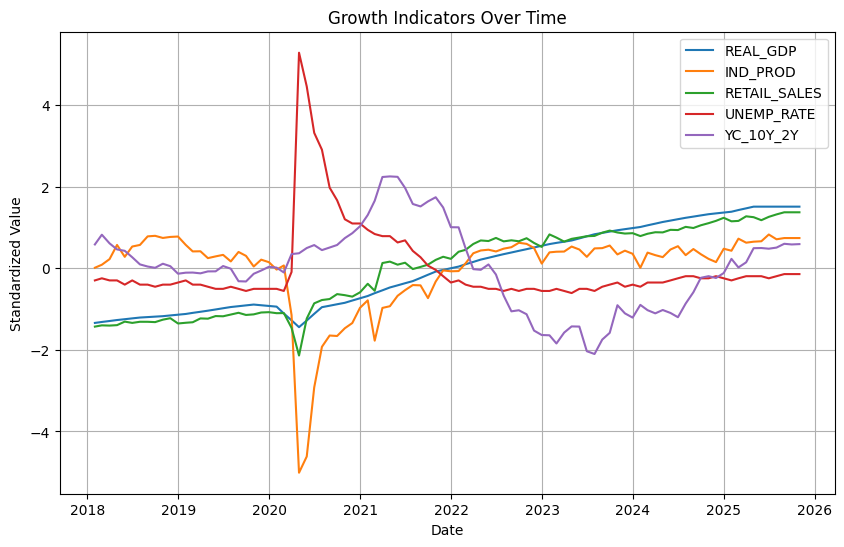

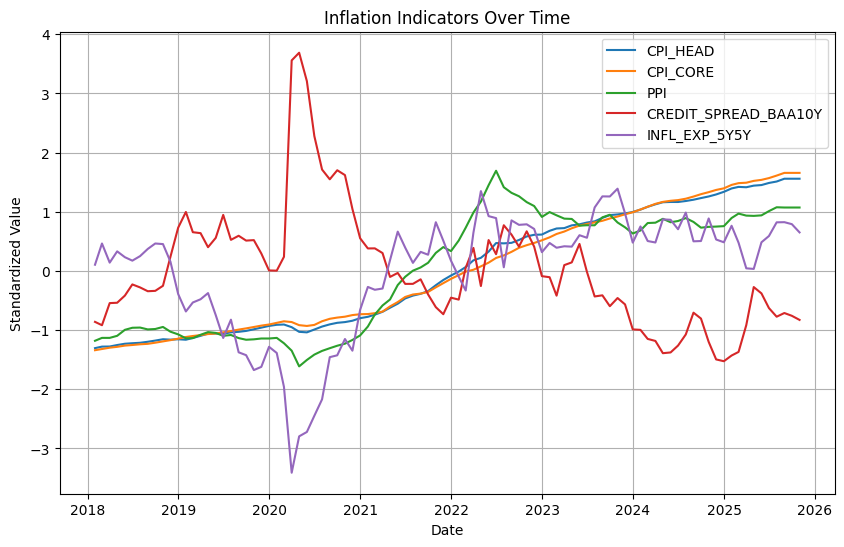

Growth Indicators Correlation Matrix:
              REAL_GDP  IND_PROD  RETAIL_SALES  UNEMP_RATE  YC_10Y_2Y
REAL_GDP      1.000000  0.414681      0.968583   -0.319688  -0.397771
IND_PROD      0.414681  1.000000      0.373788   -0.942895  -0.392765
RETAIL_SALES  0.968583  0.373788      1.000000   -0.296228  -0.306578
UNEMP_RATE   -0.319688 -0.942895     -0.296228    1.000000   0.378988
YC_10Y_2Y    -0.397771 -0.392765     -0.306578    0.378988   1.000000

Inflation Indicators Correlation Matrix:
                      CPI_HEAD  CPI_CORE       PPI  CREDIT_SPREAD_BAA10Y  \
CPI_HEAD              1.000000  0.997113  0.911510             -0.559899   
CPI_CORE              0.997113  1.000000  0.880116             -0.551616   
PPI                   0.911510  0.880116  1.000000             -0.547102   
CREDIT_SPREAD_BAA10Y -0.559899 -0.551616 -0.547102              1.000000   
INFL_EXP_5Y5Y         0.628099  0.593254  0.761462             -0.786868   
REAL_YIELD_10Y        0.698321  0.698598  0.

In [6]:
growth_indicators = [
    "REAL_GDP",
    "IND_PROD",
    "RETAIL_SALES",
    "UNEMP_RATE",
    "YC_10Y_2Y"
]

inflation_indicators = [
    "CPI_HEAD",
    "CPI_CORE",
    "PPI",
    "CREDIT_SPREAD_BAA10Y",
    "INFL_EXP_5Y5Y",
    "REAL_YIELD_10Y"
]
df_growth = merged[growth_indicators]
df_inflation = merged[inflation_indicators]
growth_indicators = [
    "REAL_GDP", "IND_PROD", "RETAIL_SALES",
    "UNEMP_RATE", "YC_10Y_2Y", "REAL_YIELD_10Y"
]

inflation_indicators = [
    "CPI_HEAD", "CPI_CORE", "PPI",
    "CREDIT_SPREAD_BAA10Y", "INFL_EXP_5Y5Y"
]

plt.figure(figsize=(10,6))
for col in growth_indicators:
    if col in df_growth.columns:
        plt.plot(df_growth.index, df_growth[col], label=col)

plt.title("Growth Indicators Over Time")
plt.xlabel("Date")
plt.ylabel("Standardized Value")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
for col in inflation_indicators:
    if col in df_inflation.columns:
        plt.plot(df_inflation.index, df_inflation[col], label=col)

plt.title("Inflation Indicators Over Time")
plt.xlabel("Date")
plt.ylabel("Standardized Value")
plt.legend()
plt.grid(True)
plt.show()

corr_matrix_growth = df_growth.corr()
corr_matrix_inflation = df_inflation.corr()
print("Growth Indicators Correlation Matrix:")
print(corr_matrix_growth)
print("\nInflation Indicators Correlation Matrix:")
print(corr_matrix_inflation)
new_growth_indicators = [
    "REAL_GDP",
    "IND_PROD",
    "UNEMP_RATE",
    "YC_10Y_2Y"
]
new_inflation_indicators = [
    "CPI_HEAD",
    "CREDIT_SPREAD_BAA10Y",
    "INFL_EXP_5Y5Y",
    "REAL_YIELD_10Y"
]
df_growth = df_growth[new_growth_indicators]
df_inflation = df_inflation[new_inflation_indicators]
df_growth["UNEMP_RATE_INV"] = -df_growth["UNEMP_RATE"]
df_inflation["REAL_YIELD_10Y_INV"] = -df_inflation["REAL_YIELD_10Y"]
print(df_growth.tail())
print(df_inflation.tail())

📊 Latest Growth Nowcast (equal-weight): 0.75
💰 Latest Inflation Nowcast (equal-weight): 0.10


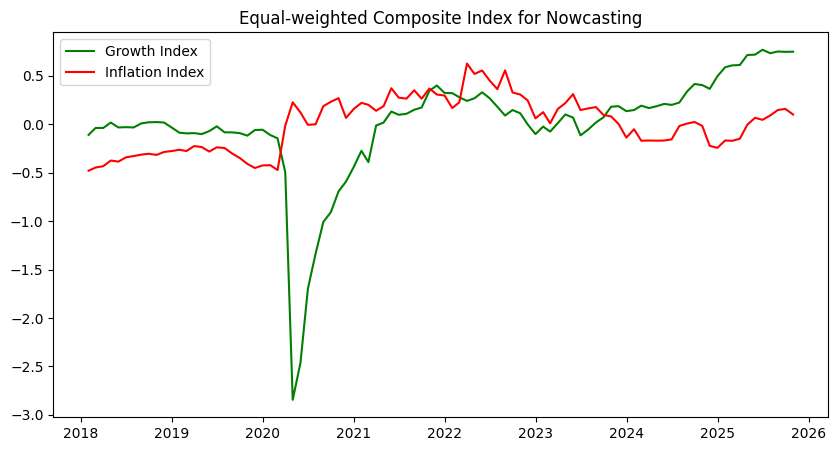

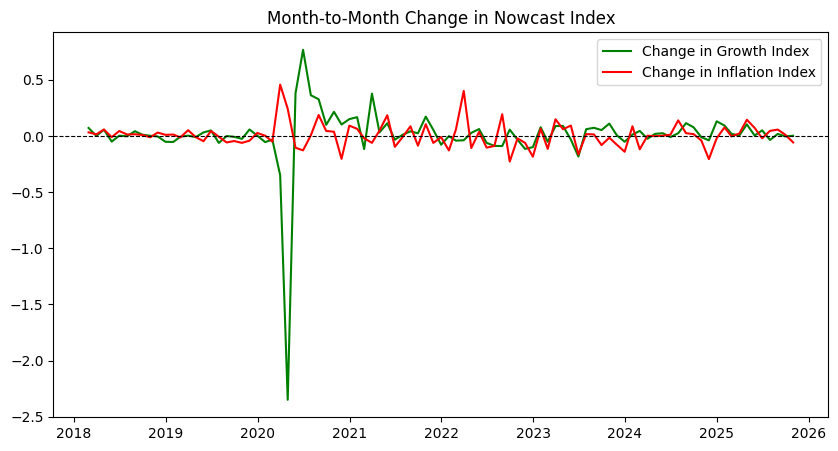

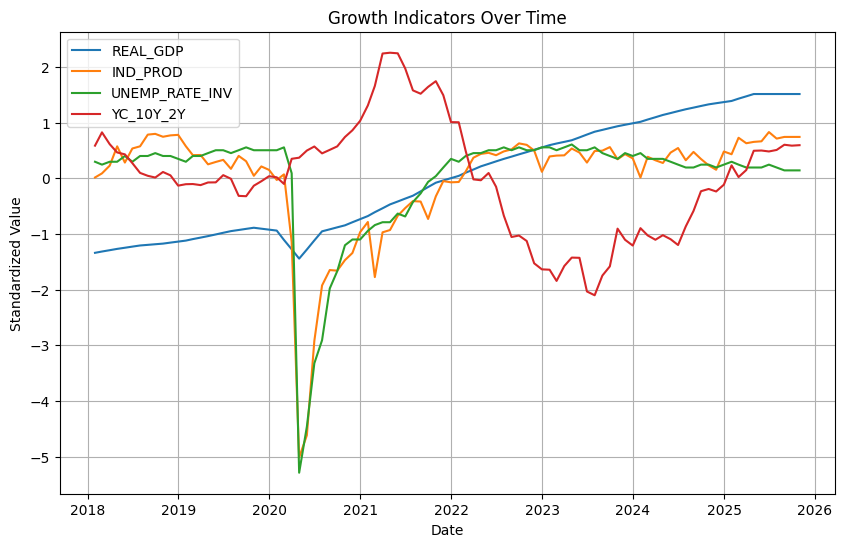

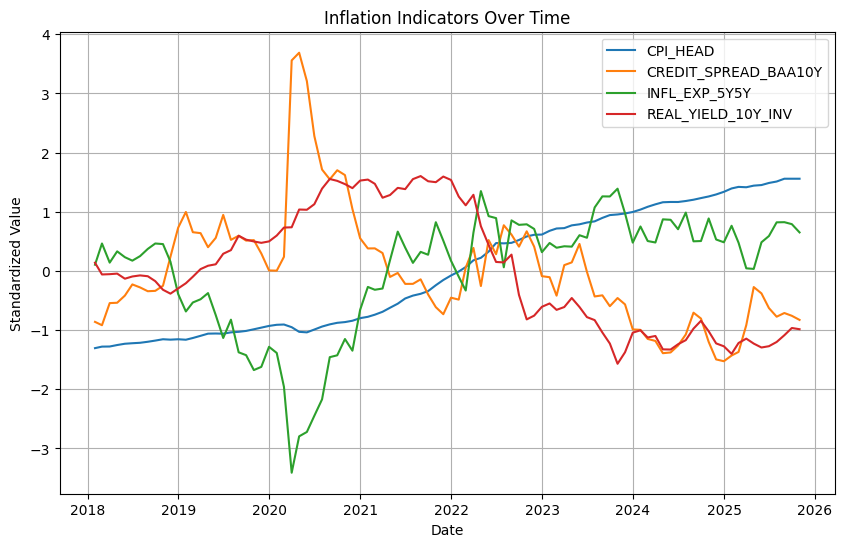

In [7]:
new_growth_indicators = [
    "REAL_GDP",
    "IND_PROD",
    "UNEMP_RATE_INV",
    "YC_10Y_2Y"
]
new_inflation_indicators = [
    "CPI_HEAD",
    "CREDIT_SPREAD_BAA10Y",
    "INFL_EXP_5Y5Y",
    "REAL_YIELD_10Y_INV"
]
df_growth["GROWTH_INDEX"] = df_growth[new_growth_indicators].mean(axis=1)
df_inflation["INFLATION_INDEX"] = df_inflation[new_inflation_indicators].mean(axis=1)
df_growth["DELTA_GROWTH_INDEX"] = df_growth["GROWTH_INDEX"].diff()
df_inflation["DELTA_INFLATION_INDEX"] = df_inflation["INFLATION_INDEX"].diff()

df_growth.to_csv("growth_index.csv")
df_inflation.to_csv("inflation_index.csv")


latest_growth_nowcast = df_growth["GROWTH_INDEX"].iloc[-1]
latest_inflation_nowcast = df_inflation["INFLATION_INDEX"].iloc[-1]

print(f"📊 Latest Growth Nowcast (equal-weight): {latest_growth_nowcast:.2f}")
print(f"💰 Latest Inflation Nowcast (equal-weight): {latest_inflation_nowcast:.2f}")

plt.figure(figsize=(10,5))
plt.plot(df_growth.index, df_growth["GROWTH_INDEX"], label="Growth Index", color="green")
plt.plot(df_inflation.index, df_inflation["INFLATION_INDEX"], label="Inflation Index", color="red")
plt.title("Equal-weighted Composite Index for Nowcasting")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(df_growth.index, df_growth["DELTA_GROWTH_INDEX"], label="Change in Growth Index", color="green")
plt.plot(df_inflation.index, df_inflation["DELTA_INFLATION_INDEX"], label="Change in Inflation Index", color="red")
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title("Month-to-Month Change in Nowcast Index")
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
for col in new_growth_indicators:
    if col in df_growth.columns:
        plt.plot(df_growth.index, df_growth[col], label=col)

plt.title("Growth Indicators Over Time")
plt.xlabel("Date")
plt.ylabel("Standardized Value")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
for col in new_inflation_indicators:
    if col in df_inflation.columns:
        plt.plot(df_inflation.index, df_inflation[col], label=col)

plt.title("Inflation Indicators Over Time")
plt.xlabel("Date")
plt.ylabel("Standardized Value")
plt.legend()
plt.grid(True)
plt.show()


In [8]:
df_growth["DELTA_GROWTH_INDEX"]     = df_growth["GROWTH_INDEX"].diff()
df_inflation["DELTA_INFLATION_INDEX"] = df_inflation["INFLATION_INDEX"].diff()

risk_df = pd.DataFrame({
    "ΔGI": df_growth["DELTA_GROWTH_INDEX"],
    "ΔII": df_inflation["DELTA_INFLATION_INDEX"]
}).dropna(how="any")

by_year = risk_df.groupby(risk_df.index.year).agg(
    sigma_dGI=("ΔGI", "std"),
    sigma_dII=("ΔII", "std")
)

by_year["MRI (sum)"] = by_year["sigma_dGI"] + by_year["sigma_dII"]

def risk_bucket(x):
    if x >= 0.80:        return "High"
    elif x >= 0.10:      return "Moderate"
    else:      return "Low"

by_year["Risk Level"] = by_year["MRI (sum)"].apply(risk_bucket)

risk_table = by_year.rename(columns={
    "sigma_dGI": "σ(ΔGI)",
    "sigma_dII": "σ(ΔII)"
}).reset_index().rename(columns={"index": "Year", 0:"Year"}).round(2)

print("Macro Risk Table (Annual Volatility of Month-to-Month Changes)")
print(risk_table.to_string(index=False))

Macro Risk Table (Annual Volatility of Month-to-Month Changes)
 DATE  σ(ΔGI)  σ(ΔII)  MRI (sum) Risk Level
 2018    0.04    0.02       0.06        Low
 2019    0.04    0.04       0.08        Low
 2020    0.78    0.18       0.96       High
 2021    0.13    0.09       0.22   Moderate
 2022    0.06    0.17       0.23   Moderate
 2023    0.09    0.10       0.18   Moderate
 2024    0.05    0.09       0.14   Moderate
 2025    0.04    0.06       0.10   Moderate


In [9]:
files.download("growth_index.csv")
files.download("inflation_index.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>